<h3>This notebook contains several models based on the InceptionResNetV2 architecture</h3>

The idea was to use that architecture as the core of the solution - with or without pretrained weights. It achieved better CIoU score than the custom built NN (in roi_detection notebook), but with one important downside - it began overfitting quite fast, was not as space efficient and training took longer. This all leads to the choice of custom built NN for ROI detection phase.

In [1]:
import os
import absl.logging

import numpy as np
import tensorflow as tf

from typing import Callable, Tuple
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from functions.ciou import ciou_loss, ciou_metric
from functions.loading_data import parse_csv
from functions.loading_data import SMALLER_HEIGHT, SMALLER_WIDTH
from functions.plotting import plot_history

absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
get_names = lambda root_path: [
    file_name.split('.')[0]
    for dir_path, _, file_names in os.walk(root_path)
    for file_name in file_names
]
get_paths = lambda path: [f'{os.path.join(root, file)}' for root, dirs, files in os.walk(path) for file in files]
base_dir = os.path.join('..', 'data', 'images_original_inception_resnet_v2_200x150_splitted')
train_dir = os.path.join(base_dir, 'training')
valid_dir = os.path.join(base_dir, 'validation')

In [3]:
def process_path(
        image_path: str,
        coords: np.ndarray) -> Tuple[tf.Tensor, np.ndarray]:
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, coords


def load_and_preprocess_data(csv_file_path: str, img_dir: str) -> tf.data.Dataset:
    image_filenames, coordinates = parse_csv(csv_file_path)
    image_filenames = [os.path.join(img_dir, fname) for fname in image_filenames]

    return tf.data.Dataset \
        .from_tensor_slices((
            image_filenames,
            coordinates)) \
        .map(process_path) \
        .batch(64) \
        .shuffle(1024)

In [4]:
train_ds = load_and_preprocess_data(os.path.join('..', 'data', 'training_boxes_basic.csv'), train_dir)
valid_ds = load_and_preprocess_data(os.path.join('..', 'data', 'validation_boxes_basic.csv'), valid_dir)

In [5]:
def run_multi_attentive_model(
        model_factory: Callable,
        model_name: str,
        loss: Callable,
        metric: Callable,
        reduction_patience=5,
        monitor='val_ciou_metric',
        train=train_ds,
        val=valid_ds):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        mode='max',
        patience=10,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=reduction_patience,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='models/' + model_name + '_{epoch}',
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=f'tensor_logs/{model_name}')
    model = model_factory(loss, metric)

    return model.fit(
        train,
        validation_data=val,
        epochs=500,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

In [13]:
def get_baseline_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 1536))(gap_layer)
        dense = keras.layers.Dense(1536, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(1536, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    attention_module = get_attention_module(base_model.output)
    flat = keras.layers.Flatten()(attention_module)
    locator_module = keras.layers.Dense(4608, activation='relu')(flat)
    locator_module = keras.layers.Dense(1024, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(base_model.input, outputs=locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    return model

In [ ]:
history1 = run_multi_attentive_model(get_baseline_model, f'roi_detection_inception_1', ciou_loss, ciou_metric, 20)

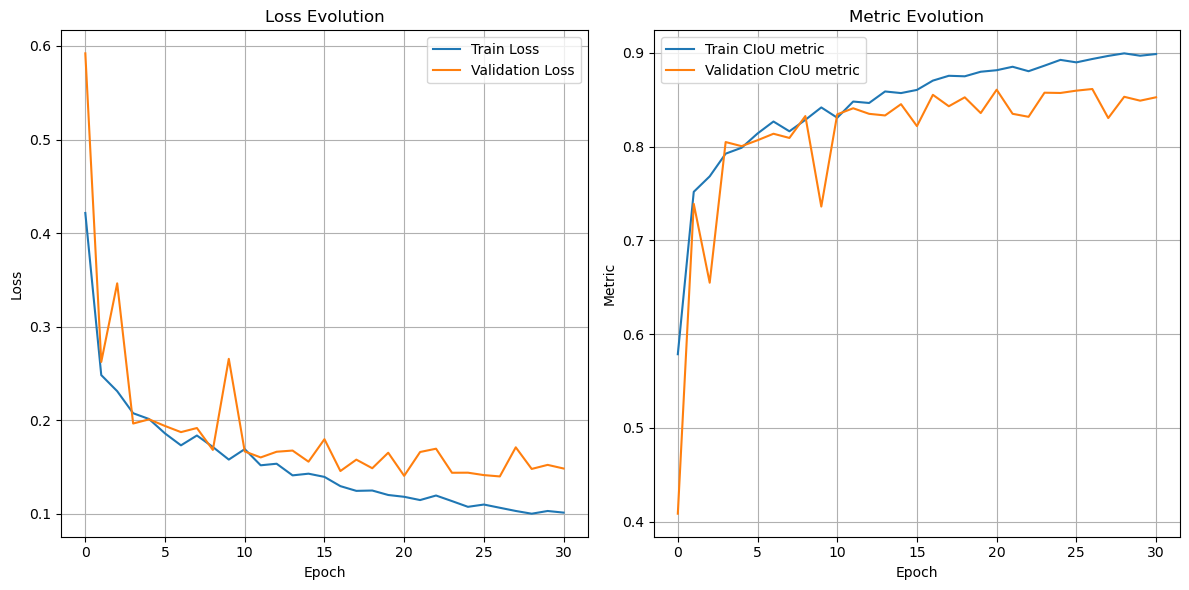

In [17]:
plot_history(history1, metric_key='ciou_metric', val_metric_key='val_ciou_metric')

In [25]:
def get_partially_unfrozen_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 1536))(gap_layer)
        dense = keras.layers.Dense(1536, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(1536, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))

    for index in range(0, len(base_model.layers) // 3):
        base_model.layers[index].trainable = False

    attention_module = get_attention_module(base_model.output)
    flat = keras.layers.Flatten()(attention_module)
    locator_module = keras.layers.Dense(4608, activation='relu')(flat)
    locator_module = keras.layers.Dense(1024, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(base_model.input, outputs=locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    return model

In [ ]:
history3 = run_multi_attentive_model(get_partially_unfrozen_model, f'roi_detection_inception_3', ciou_loss, ciou_metric, 20)

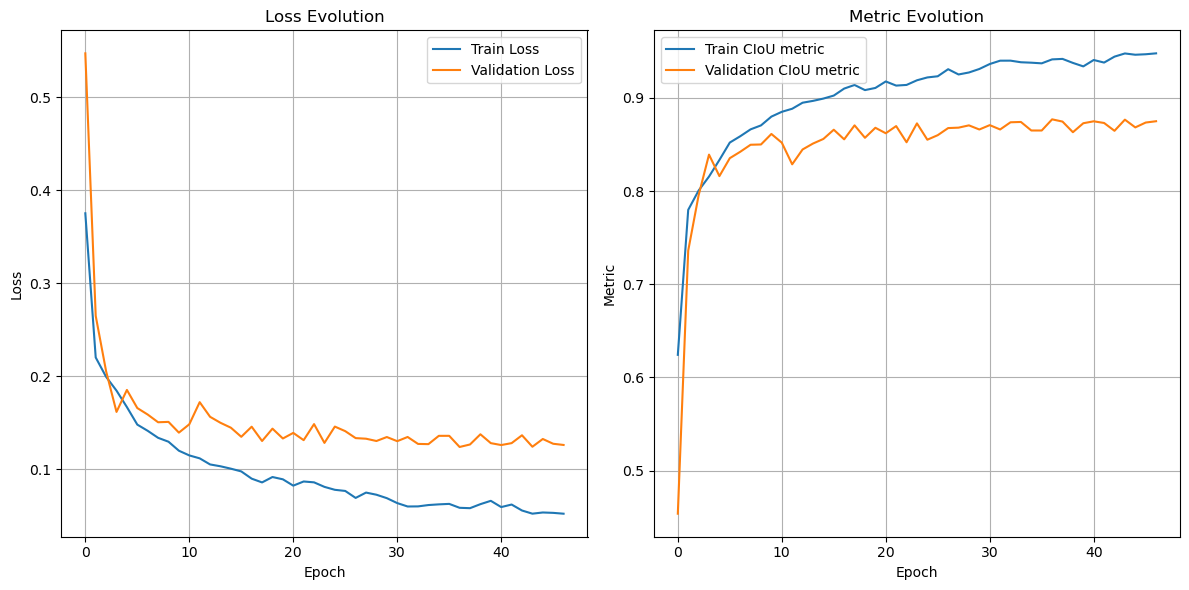

In [27]:
plot_history(history3, metric_key='ciou_metric', val_metric_key='val_ciou_metric')

In [6]:
def get_partially_unfrozen_model_with_2_attentions(loss: Callable, metric: Callable) -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 1536))(gap_layer)
        dense = keras.layers.Dense(1536, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(1536, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))

    for index in range(0, len(base_model.layers) // 3):
        base_model.layers[index].trainable = False

    attention_module1 = get_attention_module(base_model.output)
    attention_module2 = get_attention_module(base_model.output)
    merged_attentions = keras.layers.concatenate([attention_module1, attention_module2])
    locator_module = keras.layers.Flatten()(merged_attentions)
    locator_module = keras.layers.Dense(4608, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(1024, activation='relu')(locator_module)
    output = keras.layers.Dense(4, activation='sigmoid', name='root')(locator_module)
    gap_attention1 = keras.layers.GlobalAveragePooling2D()(attention_module1)
    gap_attention2 = keras.layers.GlobalAveragePooling2D()(attention_module2)
    aux_output = keras.layers.Dot(axes=1, normalize=True, name='dot')([gap_attention1, gap_attention2])

    model = keras.Model(base_model.input, outputs=[output, aux_output])

    model.compile(
        optimizer='adam',
        loss={
            'root': loss,
            'dot': keras.losses.mean_squared_error,
        },
        loss_weights={'root': 1.0, 'dot': 0.1},
        metrics={
            'root': metric,
            'dot': keras.metrics.mean_squared_error
        })

    return model

In [7]:
from functions.loading_data import load_and_preprocess_data as load_and_preprocess_data_4_attention


train_ds2 = load_and_preprocess_data_4_attention(os.path.join('..', 'data', 'training_boxes_basic.csv'), train_dir)
valid_ds2 = load_and_preprocess_data_4_attention(os.path.join('..', 'data', 'validation_boxes_basic.csv'), valid_dir)

In [ ]:
history4 = run_multi_attentive_model(get_partially_unfrozen_model_with_2_attentions, f'roi_detection_inception_4', ciou_loss, ciou_metric, 20, monitor='val_root_ciou_metric', train=train_ds2, val=valid_ds2)

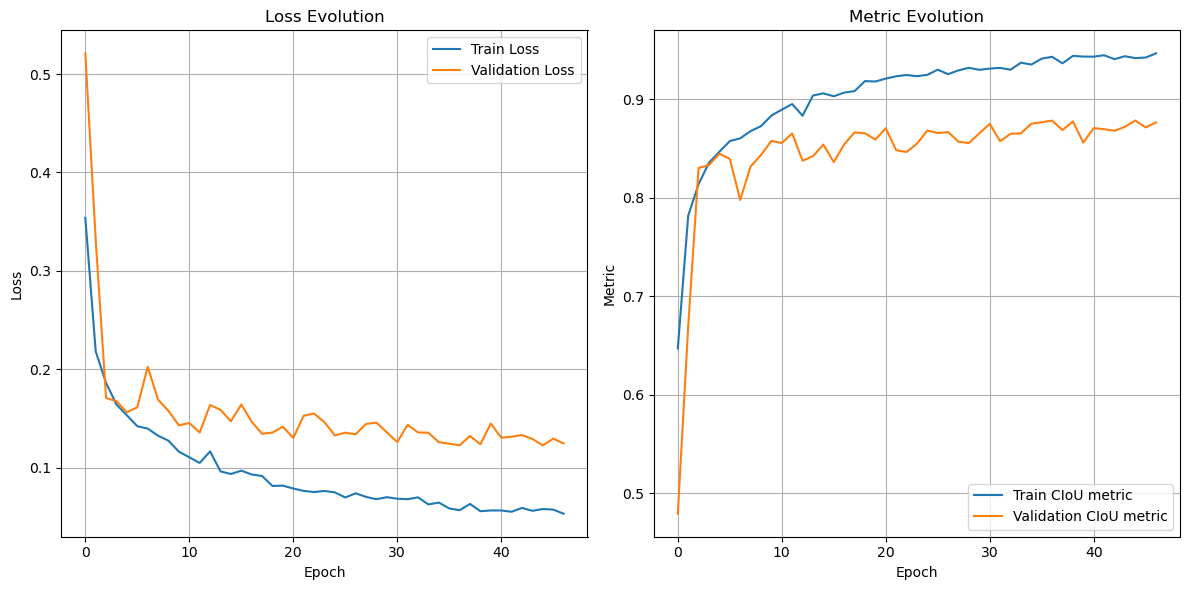

In [16]:
plot_history(history4, metric_key='root_ciou_metric', val_metric_key='val_root_ciou_metric')

In [8]:
def get_partially_unfrozen_bigger_model_with_2_attentions(loss: Callable, metric: Callable) -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 1536))(gap_layer)
        dense = keras.layers.Dense(1536, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(1536, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))

    for index in range(0, len(base_model.layers) // 3):
        base_model.layers[index].trainable = False

    attention_module1 = get_attention_module(base_model.output)
    attention_module2 = get_attention_module(base_model.output)
    merged_attentions = keras.layers.concatenate([attention_module1, attention_module2])
    locator_module = keras.layers.Flatten()(merged_attentions)
    locator_module = keras.layers.Dense(2048, activation='relu')(locator_module)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(2048, activation='relu')(locator_module)
    output = keras.layers.Dense(4, activation='sigmoid', name='root')(locator_module)
    gap_attention1 = keras.layers.GlobalAveragePooling2D()(attention_module1)
    gap_attention2 = keras.layers.GlobalAveragePooling2D()(attention_module2)
    aux_output = keras.layers.Dot(axes=1, normalize=True, name='dot')([gap_attention1, gap_attention2])

    model = keras.Model(base_model.input, outputs=[output, aux_output])

    model.compile(
        optimizer='adam',
        loss={
            'root': loss,
            'dot': keras.losses.mean_squared_error,
        },
        loss_weights={'root': 1.0, 'dot': 0.1},
        metrics={
            'root': metric,
            'dot': keras.metrics.mean_squared_error
        })

    return model

In [ ]:
history5 = run_multi_attentive_model(get_partially_unfrozen_bigger_model_with_2_attentions, f'roi_detection_inception_5', ciou_loss, ciou_metric, 20, monitor='val_root_ciou_metric', train=train_ds2, val=valid_ds2)

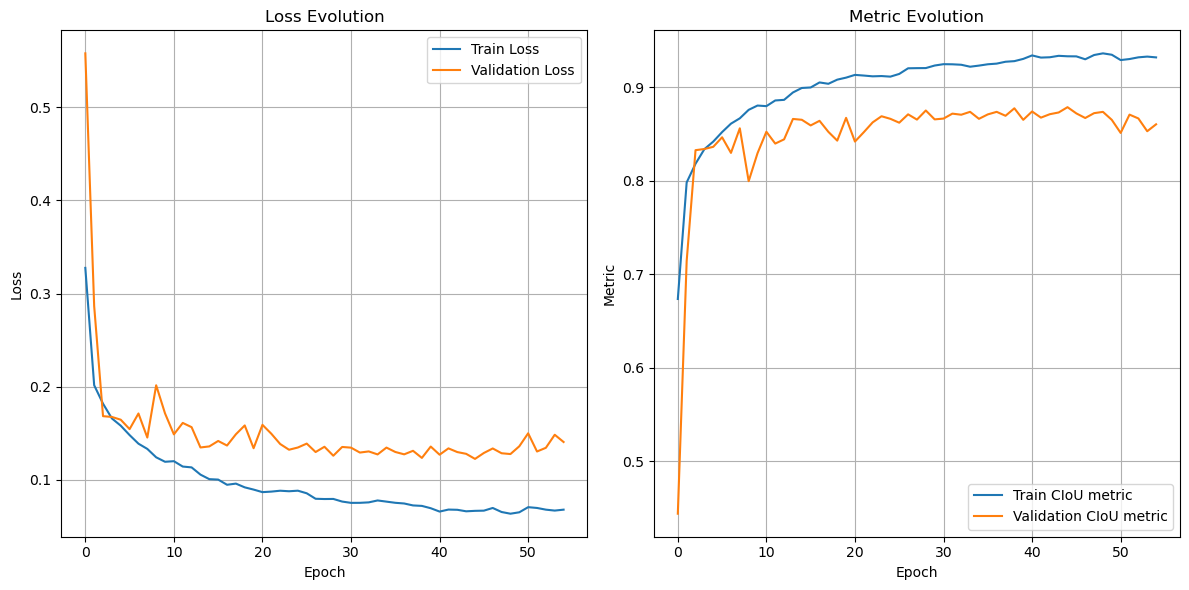

In [10]:
plot_history(history5, metric_key='root_ciou_metric', val_metric_key='val_root_ciou_metric')